# Predictors

**Created**: 21 June 2022

## Environment

In [30]:
import re
import datetime

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

## Load Data

Load eigengenes. In this case, I am including all the eigengenes (included the extended set).

In [2]:
eigen_all = pd.read_csv('/nfs/users/nfs_n/nm18/gains_team282/nikhil/expression/gene_expression/eigengenes.multiple.csv', index_col=0)

eigen_all['ID'] = [re.sub('^GA', '', x) for x in eigen_all.index.to_list()]

In [3]:
eigen_all.head()

,ME_1_1,ME_1_2,ME_1_3,ME_1_4,ME_1_5,ME_2_1,ME_2_2,ME_2_3,ME_2_4,ME_2_5,...,ME_105_2,ME_105_3,ME_105_4,ME_105_5,ME_106_1,ME_106_2,ME_106_3,ME_106_4,ME_106_5,ID
UK02270173_3,0.008640,-0.041658,0.027431,-0.020437,0.018139,0.007926,-0.038815,0.030584,-0.014329,0.009126,...,0.010338,0.031573,0.030836,-0.015560,-0.003318,0.018504,0.001776,0.034255,0.002439,UK02270173_3
UK15130120_3,-0.037073,-0.017956,-0.007283,-0.026494,0.003340,-0.033179,-0.019919,-0.016884,-0.014853,0.049310,...,-0.001612,0.005625,0.027354,-0.036702,-0.012327,0.044057,0.013145,0.017988,-0.001779,UK15130120_3
UK58000006_3,0.029671,-0.034817,0.028491,-0.009484,-0.005862,0.021490,-0.034801,0.030147,-0.003962,-0.032947,...,-0.045792,0.033492,-0.042006,0.027491,-0.004741,0.046382,-0.043310,0.028731,-0.024052,UK58000006_3
UK47010004_3,0.011955,0.010920,0.038665,0.003727,0.052019,0.007361,0.017637,0.034907,-0.005574,-0.016191,...,-0.010006,0.019263,0.000963,0.061165,0.012015,0.016376,-0.003045,-0.018223,-0.020638,UK47010004_3
UK42020088_5,0.009819,0.021002,-0.019852,-0.013053,-0.030223,0.008323,0.017129,-0.023947,0.003194,0.019716,...,-0.001258,-0.019761,-0.007900,0.029880,0.007916,-0.016497,0.013251,-0.031445,-0.014169,UK42020088_5


Clinical data, including SOFA and APACHE scores.

In [4]:
clinical = pd.read_csv('/nfs/users/nfs_n/nm18/eQTL_pQTL_Characterization/04_Expression/data/clindata_2022-06-21_11-08-38.csv')

clinical.columns = ['Sample', 'Visit', 'Diagnosis', 'SOFA', 'APACHE', 'CREAT', 'CV', 'GCS', 'BRN', 'PLT', 'RESP']

clinical['Sample'] = [re.sub('^GA', '', x) for x in clinical['Sample'].to_list()]
clinical['Visit'] = clinical['Visit'].map(lambda x: int(re.sub('Day ', '', x)))
clinical['ID'] = [f'{x}_{y}' for x, y in zip(clinical['Sample'].to_list(), clinical['Visit'].to_list())]

In [5]:
clinical.head()

,Sample,Visit,Diagnosis,SOFA,APACHE,CREAT,CV,GCS,BRN,PLT,RESP,ID
0,UK42570146,7,Community Acquired Pneumonia,0,NaN,0.0,0.0,0.0,0.0,NaN,NaN,UK42570146_7
1,UK02770067,2,Faecal Peritonitis,10,NaN,4.0,4.0,0.0,0.0,0.0,2.0,UK02770067_2
2,UK02770067,3,Faecal Peritonitis,10,NaN,4.0,4.0,0.0,0.0,0.0,2.0,UK02770067_3
3,UK02770067,1,Faecal Peritonitis,10,23.0,4.0,4.0,0.0,0.0,0.0,2.0,UK02770067_1
4,UK02770067,5,Faecal Peritonitis,10,NaN,4.0,4.0,0.0,0.0,0.0,2.0,UK02770067_5


Outcome information, including death and survival information.

In [6]:
outcome = pd.read_csv('/nfs/users/nfs_n/nm18/eQTL_pQTL_Characterization/04_Expression/data/out_2022-06-21_11-16-02.csv')

outcome.columns = ['Sample', 'Date_Admit', 'Date_Death', 'Death']

outcome['Sample'] = [re.sub('^GA', '', x) for x in outcome['Sample'].to_list()]

outcome['Date_Admit'] = outcome['Date_Admit'].map(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M'))
outcome['Date_Death'] = outcome['Date_Death'].map(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M') if type(x) == str else np.nan)
outcome['Days_to_Death'] = (outcome['Date_Death'] - outcome['Date_Admit']).dt.days
outcome['Days_to_Death'] = outcome['Days_to_Death'].map(lambda x: np.inf if np.isnan(x) else x)
outcome['Outcome'] = outcome['Days_to_Death'].map(lambda x: 'Survived' if x > 28 else 'Died')

In [7]:
outcome.head()

,Sample,Date_Admit,Date_Death,Death,Days_to_Death,Outcome
0,UK01050129,2016-11-18,NaT,0,inf,Survived
1,UK01060123,2016-02-01,NaT,0,inf,Survived
2,UK01070117,2015-11-16,NaT,0,inf,Survived
3,UK01080111,2015-04-15,NaT,0,inf,Survived
4,UK01110093,2009-09-09,NaT,0,inf,Survived


Merge all data together. Then, create two datasets: one with repeat measures and one with the first sample measurement per patient. The `full_data` contains repeat measures and the `min_data` contains the first available sample.

In [8]:
full_data = pd.merge(pd.merge(eigen_all, clinical, on='ID'), outcome, on='Sample')
full_data = full_data.set_index('ID')

In [9]:
min_samples = full_data.groupby('Sample')['Visit'].min()
min_samples = [f'{x}_{y}' for x, y in zip(min_samples.index.to_list(), min_samples.to_list())]

In [10]:
min_data = full_data.loc[min_samples, :]

## Data Exploration

In [11]:
eigen_names = [x for x in min_data.columns if re.match('^ME_[0-9]+_1', x)]
X = min_data[eigen_names]

In [12]:
pca = PCA(n_components=3).fit_transform(X)

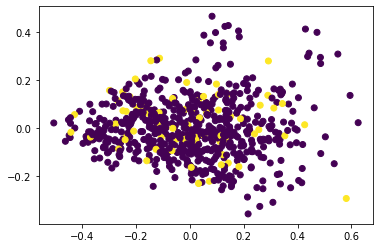

In [13]:
plt.scatter(pca[:, 0], pca[:, 1], c=pd.factorize(min_data['Outcome'])[0])

## SVM

In [82]:
eigen_names = [x for x in min_data.columns if re.match('^ME_[0-9]+', x)]
X = min_data[eigen_names].to_numpy()

y = pd.factorize(min_data['Outcome'])[0]

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [84]:
svm = SVC(kernel='rbf', class_weight='balanced')

In [85]:
svm.fit(X_train, y_train)

SVC(class_weight='balanced')

In [86]:
print(f'Training Accuracy: {svm.score(X_train, y_train)}')
print(f'Testing Accuracy: {svm.score(X_test, y_test)}')

Training Accuracy: 0.9867172675521821
Testing Accuracy: 0.8712121212121212


In [87]:
kf = KFold(n_splits=X.shape[0])

In [88]:
actual = list()
pred = list()

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    svm.fit(X_train, y_train)
    pred.append(svm.predict(X_test)[0])
    actual.append(y_test[0])

In [89]:
confusion_matrix(actual, pred)

array([[542,  39],
       [ 61,  17]])

In [94]:
x = [
    full_data[full_data['Diagnosis'] == 'Community Acquired Pneumonia']['ME_39_1'].to_list(), 
    full_data[full_data['Diagnosis'] == 'Faecal Peritonitis']['ME_39_1'].to_list()
]

{'whiskers': [<matplotlib.lines.Line2D at 0x1455fd2fb3d0>,
 'caps': [<matplotlib.lines.Line2D at 0x1455fd2d7df0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1455fd2fb100>,
 'medians': [<matplotlib.lines.Line2D at 0x1455fd2fbdf0>,
 'fliers': [<matplotlib.lines.Line2D at 0x1455fd307100>,
 'means': []}

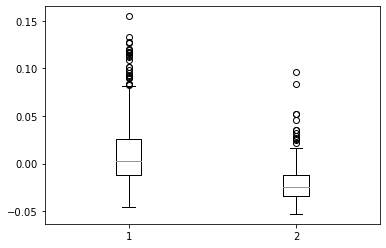

In [95]:
plt.boxplot(x)